In [1]:
from patsy import *
# 경고 무시
import warnings
warnings.simplefilter('ignore')

# 자주 사용하는 패키지를 임포트
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import pgmpy
import scipy.stats

# matplotlib 설정
mpl.use('Agg')

# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline

In [3]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, coef=True, random_state=0)
dfX0 = pd.DataFrame(X0, columns=["X"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model = sm.OLS.from_formula("Y ~ X", data=df)
result = model.fit()

print("TSS = ", result.uncentered_tss)
print("ESS = ", result.mse_model)
print("RSS = ", result.ssr)
print("ESS + RSS = ", result.mse_model + result.ssr)
print("R squared = ", result.rsquared)

TSS =  291345.75789830607
ESS =  188589.61349210917
RSS =  102754.33755137533
ESS + RSS =  291343.9510434845
R squared =  0.6473091780922586


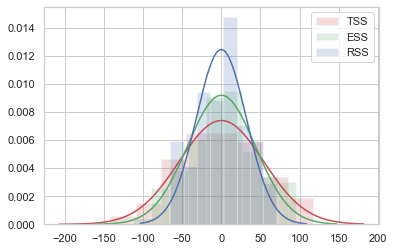

In [4]:
sns.distplot(y,
             kde=False, fit=sp.stats.norm, hist_kws={"color": "r", "alpha": 0.2}, fit_kws={"color": "r"},
             label="TSS")
sns.distplot(result.fittedvalues,
             kde=False, hist_kws={"color": "g", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "g"},
             label="ESS")
sns.distplot(result.resid,
             kde=False, hist_kws={"color": "b", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "b"},
             label="RSS")
plt.legend()
plt.show()

### 회귀 분석 F-검정과 분산 분석의 관계

In [5]:
sm.stats.anova_lm(result)

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,188589.613492,188589.613492,179.863766,6.601482e-24
Residual,98.0,102754.337551,1048.513648,NaN,NaN


In [6]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     179.9
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           6.60e-24
Time:                        12:50:50   Log-Likelihood:                -488.64
No. Observations:                 100   AIC:                             981.3
Df Residuals:                      98   BIC:                             986.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4425      3.244     -0.753      0.4

### 상수항이 없는 모형의 경우

In [7]:
X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, bias=100, coef=True, random_state=0)
dfX = pd.DataFrame(X0, columns=["X"])
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model2 = sm.OLS.from_formula("Y ~ X + 0", data=df)
result2 = model2.fit()

In [8]:
result2.rsquared

0.18768724705943896

In [9]:
### F 검정을 이용한 모형 비교

In [10]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX0_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy_boston = pd.DataFrame(boston.target, columns=["MEDV"])
dfX_boston = sm.add_constant(dfX0_boston)
df_boston = pd.concat([dfX_boston, dfy_boston], axis=1)

In [11]:
model_full = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + NOX + RM + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,494.0,11081.363952,0.0,NaN,NaN,NaN
1,492.0,11078.784578,2.0,2.579374,0.057274,0.944342


### F 검정을 사용한 변수 중요도 비교

In [13]:
model_full = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula(
    "MEDV ~ ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,493.0,11322.004277,0.0,NaN,NaN,NaN
1,492.0,11078.784578,1.0,243.219699,10.801193,0.001087


In [14]:
model_boston = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
result_boston = model_boston.fit()
sm.stats.anova_lm(result_boston, typ=2)

,sum_sq,df,F,PR(>F)
CRIM,243.219699,1.0,10.801193,1.086810e-03
ZN,257.492979,1.0,11.435058,7.781097e-04
INDUS,2.516668,1.0,0.111763,7.382881e-01
NOX,487.155674,1.0,21.634196,4.245644e-06
RM,1871.324082,1.0,83.104012,1.979441e-18
AGE,0.061834,1.0,0.002746,9.582293e-01
DIS,1232.412493,1.0,54.730457,6.013491e-13
RAD,479.153926,1.0,21.278844,5.070529e-06
TAX,242.257440,1.0,10.758460,1.111637e-03
PTRATIO,1194.233533,1.0,53.034960,1.308835e-12


### 조정 결정 계수
### 정보량 규준